# How much of protease stability is predicted by the unfolded model?

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import scipy
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from Bio import SeqIO

In [14]:
def setup_input_array(df, ec50pred=[], label_suffix='', use_pred_ec50=True):
    aas = 'FIWLVMYCATHGSQRKPNED'
    seqs = list(df['protein_sequence_c'+label_suffix])

    X = np.zeros((len(seqs),len(aas)+use_pred_ec50))
    for i, seq in enumerate(seqs):
        counts = Counter(seqs[i])
        if use_pred_ec50:
            X[i,:] = [counts[aa] for aa in aas] + [ec50pred[i]]
        else:
            X[i,:] = [counts[aa] for aa in aas]
    return X

def fit_coefficients_and_plot(df,title, label_suffix='', remove_ec50_above=1000, reg_sep_scatter=None):
    df = df[(df['ec50_t'+label_suffix] < remove_ec50_above) & (df['ec50_c'+label_suffix] < remove_ec50_above)]
    
    (fig, axs) = plt.subplots(ncols=3, figsize=[13,5])
    plt.suptitle(title)
    
    sns.set_context('talk')
      
    # Plot unfolded EC50 vs actual EC50 for chymotrypsin
    axs_i = 1
    sns.scatterplot('ec50_pred_c'+label_suffix,'ec50_c'+label_suffix, data=df, ax=axs[axs_i])
    r2 = np.round(stats.pearsonr(df['ec50_pred_c'+label_suffix], df['ec50_c'+label_suffix])[0] ** 2,2)
    axs[axs_i].set_title('r2=' + str(r2))
    d1 = df['ec50_pred_c'+label_suffix] - df['ec50_c'+label_suffix]
         
    
    
    # Plot unfolded EC50 vs actual EC50 for trypsin
    axs_i= 0
    sns.scatterplot('ec50_pred_t'+label_suffix,'ec50_t'+label_suffix, data=df, ax=axs[axs_i])
    r2 = np.round(stats.pearsonr(df['ec50_pred_t'+label_suffix], df['ec50_t'+label_suffix])[0] ** 2,2)
    axs[axs_i].set_title('r2=' + str(r2))
    d2 = df['ec50_pred_t'+label_suffix] - df['ec50_t'+label_suffix]
    d = d1.append(d2)

    # Do the proteases agree?
    axs_i = 2
    sns.scatterplot('ec50_c'+label_suffix,'ec50_t'+label_suffix, data=df, ax=axs[axs_i])
    r2 = np.round(stats.pearsonr(df['ec50_t'+label_suffix], df['ec50_c'+label_suffix])[0] ** 2,2)
    axs[axs_i].set_title('r2=' + str(r2))
    
    # Train and plot weights
    aas = 'FIWLVMYCATHGSQRKPNED'
    (fig, axs) = plt.subplots(nrows=2, ncols=4, figsize=[15,10], sharey='row')
    axs_i = 0
    models = {}
    L1_RATIOs = [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.3, .5, .7, .9, .95, .99, 0.999, 0.9999, 0.99999, 1]
    for protease in ['t','c']:
        for use_pred_ec50 in [1, 0]:
            ec50pred = list(df['ec50_pred_' + protease + label_suffix])
            X = setup_input_array(df, ec50pred, label_suffix=label_suffix, use_pred_ec50=use_pred_ec50)
            scores = np.array(df['ec50_' + protease +label_suffix])
             
            # Train
            df_train, df_test = train_test_split(df, test_size=0.20, random_state=42)
            
            X_train, X_test, scores_train_raw, scores_test_raw = train_test_split(X, scores, test_size=0.20, random_state=42)
            ave = np.mean(scores_train_raw)
            std = np.std(scores_train_raw)
            scores_train = (scores_train_raw-ave)/std
            scores_test = (scores_test_raw-ave)/std
            
            ave_all = np.mean(scores)
            std_all = np.std(scores)
            scores_train_all = (scores-ave_all)/std_all
                        
            model = linear_model.ElasticNetCV(l1_ratio=L1_RATIOs, n_jobs=1, cv=5, verbose=False)
            model.fit(X_train[:,:], scores_train)
            
            model_all_data = linear_model.ElasticNetCV(l1_ratio=L1_RATIOs, n_jobs=1, cv=5, verbose=False)
            model_all_data.fit(X[:,:], scores_train_all)

            models['protease_'+protease+'_useUSM_'+str(use_pred_ec50)] = model
            models['protease_'+protease+'_useUSM_'+str(use_pred_ec50)+'_sawAllData'] = model_all_data
            models['protease_'+protease+'_useUSM_'+str(use_pred_ec50)+'_ave_and_std'] = (ave,std)
            models['protease_'+protease+'_useUSM_'+str(use_pred_ec50)+'_sawAllData'+'_ave_and_std'] = (ave_all,std_all)


            # Evaluate and plot weights
            score_train = model.score(X_train[:,:], scores_train)
            score_test = model.score(X_test[:,:], scores_test)
            coefficients = model.coef_
            labels = list(aas) + ['u'] if use_pred_ec50 else list(aas)
            sns.barplot(labels, coefficients, ax=axs[0, axs_i])
            axs[0, axs_i].set_title(protease + ',uf=' + str(use_pred_ec50)+' r2h='+str(np.round(score_test,2)))
            
            # Plot correlation
            if reg_sep_scatter is None:
                y_true = scores_test
                y_pred = model.predict(X_test)*std + ave
                d = {'EC50_true_'+protease: y_true, 'EC50_pred_'+protease: y_pred}
                x = pd.DataFrame.from_dict(d)
                sns.scatterplot(x['EC50_pred_'+protease], x['EC50_true_'+protease], ax=axs[1, axs_i])
                r2 = scipy.stats.pearsonr(x['EC50_pred_'+protease],x['EC50_true_'+protease])[0]**2
                axs[1, axs_i].set_title(protease + ',uf=' + str(use_pred_ec50)+' r2h='+str(np.round(r2,2)))
            else:
                df_test_chip1 = df_test[~df_test['name'].str.contains(pat = reg_sep_scatter, regex=True)]
                df_test_chip2 = df_test[df_test['name'].str.contains(pat = reg_sep_scatter, regex=True)] 

                X_test_chip1 = setup_input_array(df_test_chip1, ec50pred, label_suffix=label_suffix, use_pred_ec50=use_pred_ec50)
                X_test_chip2 = setup_input_array(df_test_chip2, ec50pred, label_suffix=label_suffix, use_pred_ec50=use_pred_ec50)
                
                scores_test_chip1 = np.array(df_test_chip1['ec50_' + protease +label_suffix])
                scores_test_chip2 = np.array(df_test_chip2['ec50_' + protease +label_suffix])
                
                y_pred_chip1 = model.predict(X_test_chip1)*std + ave
                y_pred_chip2 = model.predict(X_test_chip2)*std + ave
                
                d1 = {'EC50_true': scores_test_chip1, 'EC50_pred': y_pred_chip1}
                d2 = {'EC50_true': scores_test_chip2, 'EC50_pred': y_pred_chip2}
                x1 = pd.DataFrame.from_dict(d1)
                x2 = pd.DataFrame.from_dict(d2)
                
                sns.scatterplot(x1['EC50_pred'], x1['EC50_true'], ax=axs[1, axs_i], color='blue')
                sns.scatterplot(x2['EC50_pred'], x2['EC50_true'], ax=axs[1, axs_i], color='orange')
                
                r2_1 = scipy.stats.pearsonr(x1['EC50_pred'],x1['EC50_true'])[0]**2
                r2_2 = scipy.stats.pearsonr(x2['EC50_pred'],x2['EC50_true'])[0]**2
                axs[1, axs_i].set_title('r2_1='+str(np.round(r2_1,2))+' r2_2='+str(np.round(r2_2,2)))# +' r2_12='+str(np.round(r2_12,2))
            
            axs_i += 1
    
    plt.tight_layout()
    return models

# Get data and train for individual chips

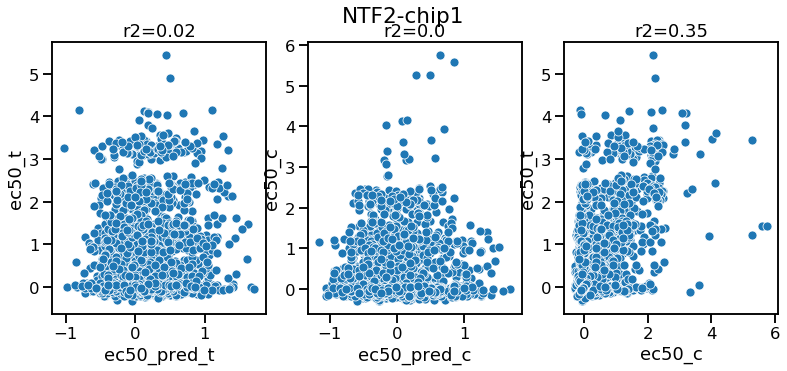

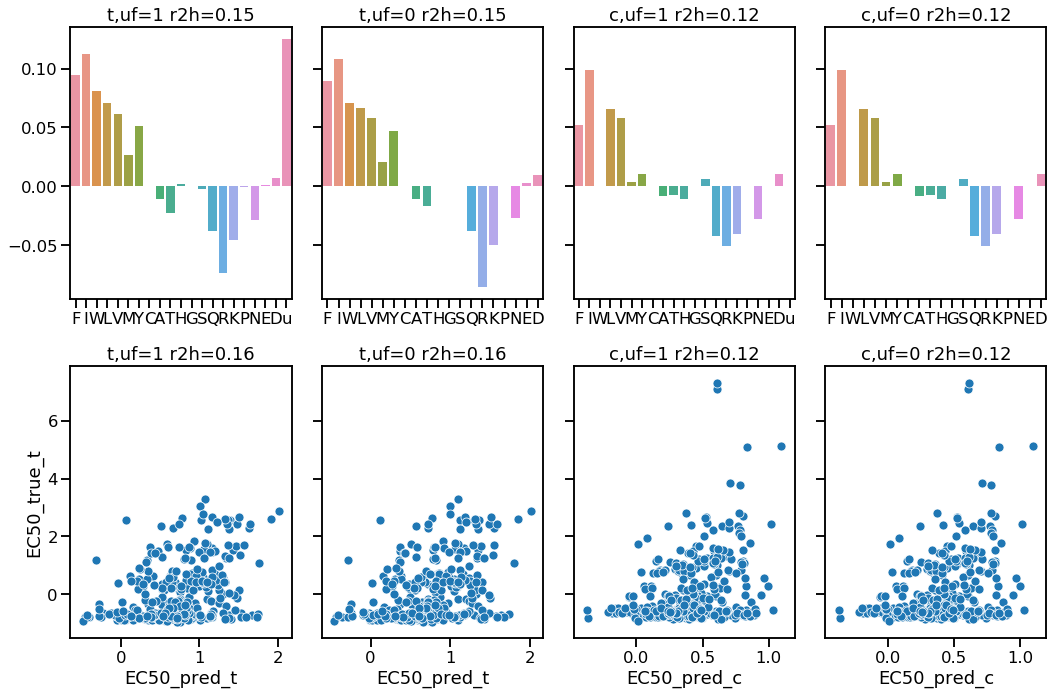

In [15]:
#############################
# Get dataframe for chip 1
#############################
f = 'chip1_NTF2_unfolded_and_calc_EC50s.tab'
df = pd.read_csv(f, delim_whitespace=True)
df = df[df['Design'].str.startswith('sc')]
df = df[(df['tryp_width_EC50']*np.log10(3) < 2) & (df['chymo_width_EC50']*np.log10(3) < 2)]

# add seqs
inAlnPath = 'chip1_all_seqs.fasta'
f_open = open(inAlnPath, "rt") # "data/design_paths.linsi.aln.fasta"
pdb_seqs = SeqIO.to_dict(SeqIO.parse(f_open, "fasta"))
seq_list = []
for n in df['Design']:
    if n not in pdb_seqs:
        seq_list.append('MISSING_SEQUENCE')
    else:
        c = Counter(pdb_seqs[n].seq)
        if c['C'] > 0:
            seq_list.append('cysteine_sequence')
        else:
            seq_list.append(str(pdb_seqs[n].seq))    
df['protein_sequence_c'] = seq_list
df = df[~df['protein_sequence_c'].str.contains('MISSING_SEQUENCE')]
df = df[~df['protein_sequence_c'].str.contains('cysteine_sequence')]

# Rename columns
df.columns = ['name','ec50_t','ec50_c','ec50_t_lower','ec50_c_lower','ec50_t_higher','ec50_c_higher','ec50_t_width','ec50_c_width','ec50_pred_t','ec50_pred_c','protein_sequence_c']
models1 = fit_coefficients_and_plot(df,'NTF2-chip1')
df_ntf2_1 = df.copy()


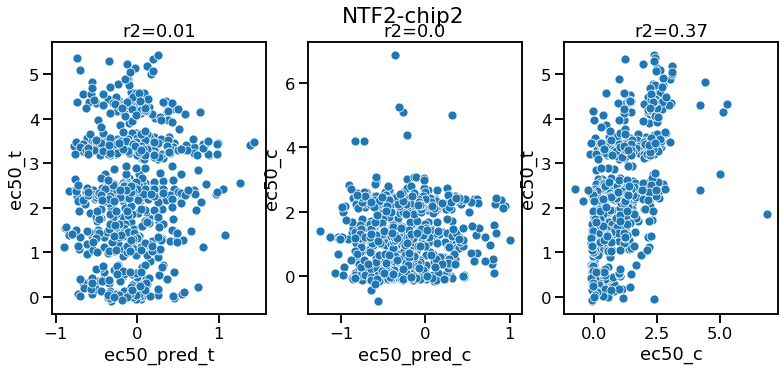

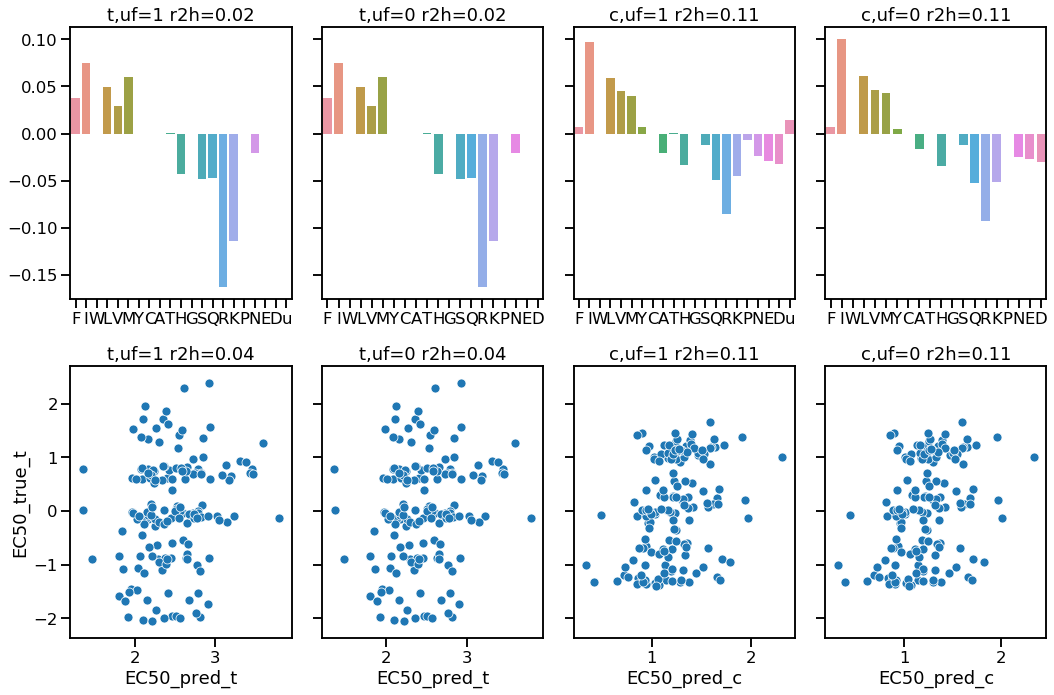

In [16]:
#############################
# Get dataframe for chip 2
#############################
f = 'chip2_NTF2_unfolded_and_calc_EC50s.tab'
df = pd.read_csv(f,delim_whitespace=True)
df = df[df['Design'].str.startswith('scr_')]
df = df[(df['tryp_width_EC50']*np.log10(3) < 2) & (df['chymo_width_EC50']*np.log10(3) < 2)]

# add seqs
inAlnPath = 'chip2_all_seqs.fasta'
f_open = open(inAlnPath, "rt") 
pdb_seqs = SeqIO.to_dict(SeqIO.parse(f_open, "fasta"))
seq_list = []

for n in df['Design']:
    if n not in pdb_seqs:
        seq_list.append('MISSING_SEQUENCE')
    else:
        c = Counter(pdb_seqs[n].seq)
        if c['C'] > 0:
            seq_list.append('cysteine_sequence')
            print(n)
        else:
            seq_list.append(str(pdb_seqs[n].seq))    

df['protein_sequence_c'] = seq_list
df = df[~df['protein_sequence_c'].str.contains('MISSING_SEQUENCE')]
df = df[~df['protein_sequence_c'].str.contains('cysteine_sequence')]

            
# Rename columns
df.columns = ['name','ec50_t','ec50_c','ec50_t_lower','ec50_c_lower','ec50_t_higher','ec50_c_higher','ec50_95ci_t','ec50_95ci_c','ec50_pred_t','ec50_pred_c','protein_sequence_c']

models2 = fit_coefficients_and_plot(df,'NTF2-chip2')

df_ntf2_2 = df.copy()

# Combine the dataset to get more power and fit models

Note that the ec50 distributions look somewhat different between the two chip orders. The differences makes sense. In chip2 things become more hydrophobic giving higher molten globule propensity (therefore higher ec50_t values), but add the same time adding more chymotrypsin cutsites (ec50_c almost maintained).

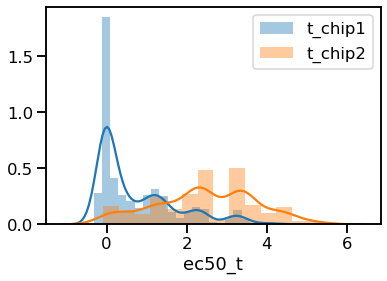

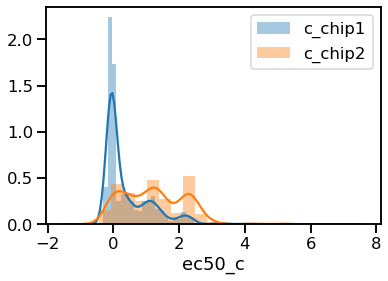

In [17]:
sns.distplot(df_ntf2_1['ec50_t'],label='t_chip1')
sns.distplot(df_ntf2_2['ec50_t'],label='t_chip2')
plt.legend()
plt.figure()
sns.distplot(df_ntf2_1['ec50_c'],label='c_chip1')
sns.distplot(df_ntf2_2['ec50_c'],label='c_chip2')
plt.legend()

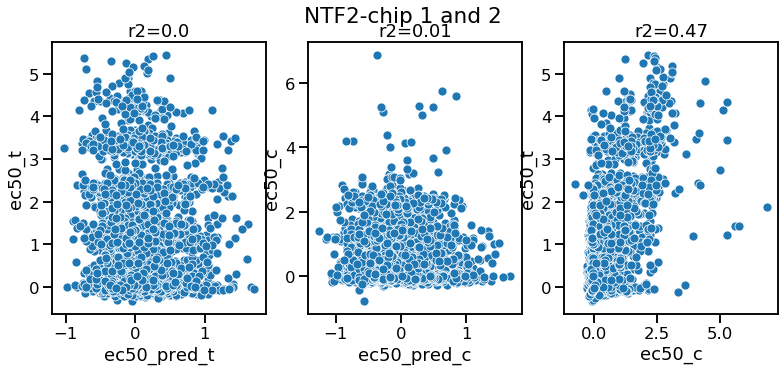

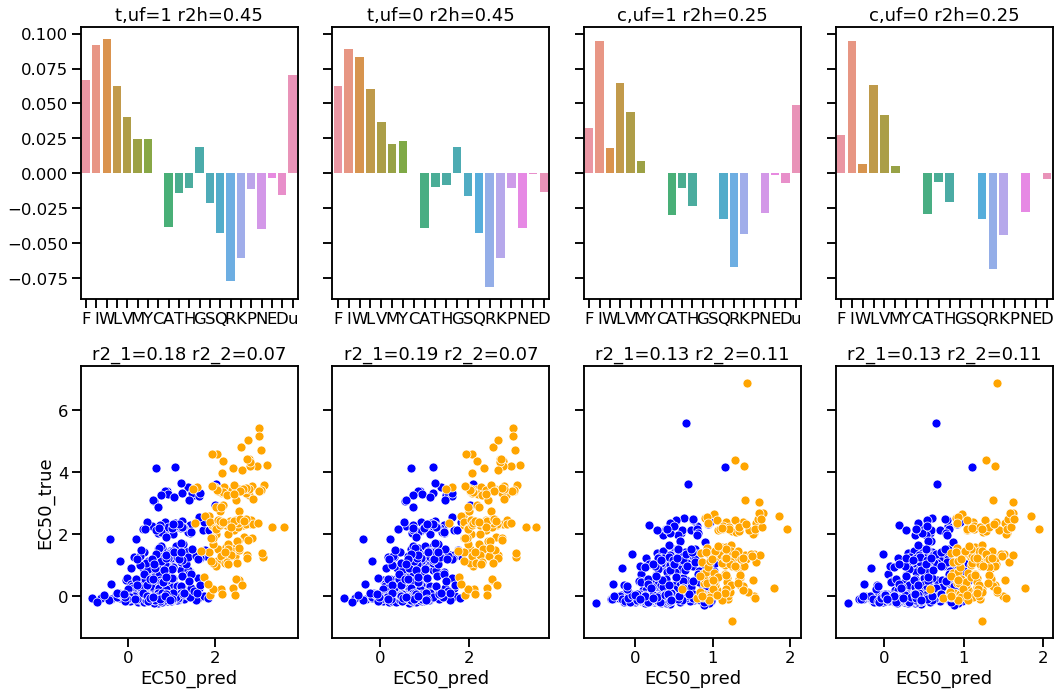

In [18]:
# Combine datasets and train
df_scram_12 = pd.concat([df_ntf2_1,df_ntf2_2], sort=False)
models12 = fit_coefficients_and_plot(df_scram_12,'NTF2-chip 1 and 2', reg_sep_scatter='_[A-Z]{8}')

The combined data improves correlation across all data, within each chip, and seems to reinforce the weights. Now we take the model trained on all data and apply it to the sequences from chip 1 and 2. 

In [20]:
############################################################
# Load in the data for both chips only removing seqs w cys #
############################################################
# Chip 1
f = 'chip1_NTF2_unfolded_and_calc_EC50s.tab'
df1 = pd.read_csv(f, delim_whitespace=True)

# add seqs
inAlnPath = 'chip1_all_seqs.fasta'
f_open = open(inAlnPath, "rt") # "data/design_paths.linsi.aln.fasta"
pdb_seqs = SeqIO.to_dict(SeqIO.parse(f_open, "fasta"))

seq_list = []
for n in df1['Design']:
    if n not in pdb_seqs:
        print("Missing ",n)
        seq_list.append('MISSING_SEQUENCE')
    else:
        c = Counter(pdb_seqs[n].seq)
        if c['C'] > 0:
            #print("removing ",n,"bc cys")
            seq_list.append('cysteine_sequence')
        else:
            seq_list.append(str(pdb_seqs[n].seq))    

df1['protein_sequence_c'] = seq_list
df1 = df1[~df1['protein_sequence_c'].str.contains('MISSING_SEQUENCE')]
df1 = df1[~df1['protein_sequence_c'].str.contains('cysteine_sequence')]

df1.columns = ['name','ec50_t','ec50_c','ec50_t_lower','ec50_c_lower','ec50_t_higher','ec50_c_higher','ec50_95ci_t','ec50_95ci_c','ec50_pred_t_USM','ec50_pred_c_USM','protein_sequence_c']
df1['chip_order'] = ['chip1'] * len(df1)

# Chip 2
f = 'chip2_NTF2_unfolded_and_calc_EC50s.tab'
df2 = pd.read_csv(f,delim_whitespace=True)

inAlnPath = 'chip2_all_seqs.fasta'
f_open = open(inAlnPath, "rt") 
pdb_seqs = SeqIO.to_dict(SeqIO.parse(f_open, "fasta"))
seq_list = []
for n in df2['Design']:
    if n not in pdb_seqs:
        print("Missing ",n)
        seq_list.append('MISSING_SEQUENCE')
    else:
        c = Counter(pdb_seqs[n].seq)
        if c['C'] > 0:
            #print("removing ",n,"bc cys")
            seq_list.append('cysteine_sequence')
        else:
            seq_list.append(str(pdb_seqs[n].seq))    


df2['protein_sequence_c'] = seq_list
df2 = df2[~df2['protein_sequence_c'].str.contains('MISSING_SEQUENCE')]
df2 = df2[~df2['protein_sequence_c'].str.contains('cysteine_sequence')]

df2.columns = ['name','ec50_t','ec50_c','ec50_t_lower','ec50_c_lower','ec50_t_higher','ec50_c_higher','ec50_95ci_t','ec50_95ci_c','ec50_pred_t_USM','ec50_pred_c_USM','protein_sequence_c']
df2['chip_order'] = ['chip2'] * len(df2)

In [25]:
# Concat the chips
df12 = pd.concat([df1,df2])

# Get the counts of each amino acid for each position
X = setup_input_array(df12, use_pred_ec50=False)
ec50_USM_t = list(df12['ec50_pred_t_USM'])
ec50_USM_c = list(df12['ec50_pred_c_USM'])

#X = setup_input_array(df12, use_pred_ec50=False)
X_t = setup_input_array(df12, ec50pred=ec50_USM_t, use_pred_ec50=True) 
X_c = setup_input_array(df12, ec50pred=ec50_USM_c, use_pred_ec50=True)

# Calculate EC50_pred_x for both proteases based only on the counts
EC50_pred_t = models12['protease_t_useUSM_1_sawAllData'].predict(X_t)
EC50_pred_c = models12['protease_c_useUSM_1_sawAllData'].predict(X_c)

ave_t, std_t = models12['protease_t_useUSM_1_sawAllData_ave_and_std']
ave_c, std_c = models12['protease_c_useUSM_1_sawAllData_ave_and_std']
df12['ec50_pred_t_MGM'] = models12['protease_t_useUSM_1_sawAllData'].predict(X_t) * std_t + ave_t
df12['ec50_pred_c_MGM'] = models12['protease_c_useUSM_1_sawAllData'].predict(X_c) * std_c + ave_c

df12['stabilityscore_t_MGM'] = df12['ec50_t'] - df12['ec50_pred_t_MGM']
df12['stabilityscore_c_MGM'] = df12['ec50_c'] - df12['ec50_pred_c_MGM']
df12['stabilityscore_MGM'] = df12[['stabilityscore_t_MGM','stabilityscore_c_MGM']].min(axis=1)

df12['stabilityscore_t_USM'] = df12['ec50_t'] - df12['ec50_pred_t_USM']
df12['stabilityscore_c_USM'] = df12['ec50_c'] - df12['ec50_pred_c_USM']
df12['stabilityscore_USM'] = df12[['stabilityscore_t_USM','stabilityscore_c_USM']].min(axis=1)

df12.to_csv('chip12_comp_USM_n_stability.csv')